<a href="https://colab.research.google.com/github/little-silence/MAIS-202/blob/master/Deliverable-2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**Deliverable 2**



1. Problem statement:

  The goal of this project is to associate a doodle with the english word equivalent of what it represents.

2. Data Preprocessing:

  I will be using the categories.txt file provided by the Google Creative Lab GitHub to get the objects for which we have the data.
https://raw.githubusercontent.com/googlecreativelab/quickdraw-dataset/master/categories.txt

  In the same repository, they have also provided the datasets in four different format. I will be working with the Numpy Bitmaps provided.

  https://console.cloud.google.com/storage/browser/quickdraw_dataset/full/numpy_bitmap

  This preprocessed data provides a centered drawing(final result), rescaled to a 28x28 image represented in by a matrix of grayscale values of the same size. In otherwords, it allows us to skip the data cleaning step.

3. Machine learning model:

  In the first deliverable, I have proposed a decision tree paired with stroke recognition. As my TPM pointed out, a neural network is more suitable for this scenario.

  The model I have chosen to implement is the Convolutional Neural Network. It capture what I have been wanting to achieve: recognizing the different features in a doodle to guess the object drawn with the help of filters. I have been following code from the following address to write the model I will be using

  https://github.com/zaidalyafeai/zaidalyafeai.github.io/blob/master/sketcher/Sketcher.ipynb

  Since the Google dataset contains so muh data, I have decided to only run my test on only 20 object categ ories, and 6000 datapoints from each to allow for faster training. For the final version, it will be best to train on a larger dataset. I opted for a 60:40 split for train+valid and test due to the number of datapoints available, and 80:20 split within the train and validation set. The number of convolutional layers, as well as the output dimensions, and the filter sizes, and hyperparameters have been taken from the tutorial. To optimize, the loss function proposed is the Adam Optimizer. It is a stochastic function, which performs well with non static data and noise. This seems like an appropriate choice with the amount of noise in the dataset. 

  The model at this point seems a little overfit. Although The concept of this model has been understood, I still need to understand the specifics, such as the number of layers, size of filters, optimization function, and many other hyperparameter.

In [1]:
# import the google drawing categories
!wget 'https://raw.githubusercontent.com/googlecreativelab/quickdraw-dataset/master/categories.txt'


--2020-02-16 17:52:11--  https://raw.githubusercontent.com/googlecreativelab/quickdraw-dataset/master/categories.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2791 (2.7K) [text/plain]
Saving to: ‘categories.txt’

categories.txt      100%[===================>]   2.73K  --.-KB/s    in 0s      

2020-02-16 17:52:11 (80.0 MB/s) - ‘categories.txt’ saved [2791/2791]



In [0]:
f = open("categories.txt","r")
# And for reading use
categories = f.readlines()
f.close()

In [3]:
category = [c.replace('\n','').replace(' ','_') for c in categories]
# There is too much data, so for now, I will only be analysing the 20 first categories
short_length = 20
short = category[:short_length]
print(short)


['aircraft_carrier', 'airplane', 'alarm_clock', 'ambulance', 'angel', 'animal_migration', 'ant', 'anvil', 'apple', 'arm', 'asparagus', 'axe', 'backpack', 'banana', 'bandage', 'barn', 'baseball', 'baseball_bat', 'basket', 'basketball']


In [0]:
!mkdir data

In [0]:
import urllib.request

#Get the data from Google Quickdraw
def download():
  
  base = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'
  for element in short:
    end_url = element.replace('_', '%20')
    path = base+end_url+'.npy'
    print(path)
    urllib.request.urlretrieve(path, 'data/'+element+'.npy')

In [6]:
download()

https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/aircraft%20carrier.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/airplane.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/alarm%20clock.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/ambulance.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/angel.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/animal%20migration.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/ant.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/anvil.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/apple.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/arm.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/asparagus.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/axe.npy
https://storage.googleapis.com/quickd

In [7]:
import os
import glob
import numpy as np
from tensorflow.keras import layers
from tensorflow import keras 
import tensorflow as tf

In [0]:

def load_data(root, vfold_ratio=0.2, max_items_per_class= 50000 ):
    # get names of all .npy files in str wrapper
    all_files = glob.glob(os.path.join(root, '*.npy'))
    #find the features of this dataset
    temp = np.load(all_files[0], allow_pickle=True)
    dim = len(temp[0])
    

    #initialize variables
    x = np.empty([0,dim])
    y = np.empty([0])
    class_names = []

    #load a subset of the data to memory 
    for idx, file in enumerate(all_files):
        data = np.load(file)
        try:
          # take the specified number of data
          data = data[: max_items_per_class]
        except:
          # when number specified is larger
          pass
        labels = np.full(data.shape[0], idx)

        # append to variable
        x = np.concatenate((x, data), axis=0)
        y = np.append(y, labels)

        class_name = (file.replace(".npy",'')).replace("data/",'')
        class_names.append(class_name)

    data = None
    labels = None

    #shuffle & separate into training and testing 
    permutation = np.random.permutation(y.shape[0])
    x = x[permutation]
    y = y[permutation]

    vfold_size = int(len(x)*vfold_ratio)

    x_test = x[0:vfold_size]
    y_test = y[0:vfold_size]

    x_train = x[vfold_size:x.shape[0]]
    y_train = y[vfold_size:y.shape[0]]
    return x_train, y_train, x_test, y_test, class_names

In [0]:
import math

x_train, y_train, x_test, y_test, class_names = load_data('data',0.4,6000)
num_classes = len(class_names)
image_size = int(math.sqrt(len(x_train[0])))

asparagus


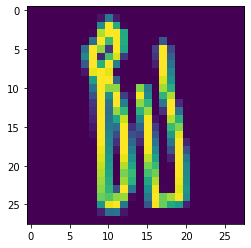

In [10]:
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline  
idx = randint(0, len(x_train))
plt.imshow(x_train[idx].reshape(28,28)) 
print(class_names[int(y_train[idx].item())])

In [0]:
# Reshape and normalize
x_train = x_train.reshape(x_train.shape[0], image_size, image_size, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], image_size, image_size, 1).astype('float32')

# pixel value is within range [0,255] we want the value to be less than 1
x_train /= 255.0
x_test /= 255.0

# Convert class vectors to class matrices
# so we can do categorical cross entropy(used when one answer out of all categories is right)
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

I still dont understand why the pooling layer parameter, I will have to look into it soon.

In [12]:
#Construct Model
model = keras.Sequential()
# first conv layer outputs 16 features with 3 by 3 filter
model.add(layers.Convolution2D(16, (3, 3),
                        padding='same',
                        input_shape=x_train.shape[1:], activation='relu'))
# pooling layer summarizes what the conv layer finds
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(32, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(64, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size =(2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
# conclude with softmax to find node with highest value
model.add(layers.Dense(short_length, activation='softmax')) 
# Train model
# adam is a stochastic function, good for changing result and good with noisy data
adam = tf.train.AdamOptimizer()
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['top_k_categorical_accuracy'])
print(model.summary())

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________

In [13]:
model.fit(x = x_train, y = y_train, validation_split=0.2, batch_size = 256, verbose=2, epochs=5)

#evaluate on test data
score = model.evaluate(x_test, y_test)
print('Test accuracy: {:0.2f}%'.format(score[1] * 100))

Train on 57600 samples, validate on 14400 samples
Epoch 1/5
57600/57600 - 43s - loss: 1.5266 - top_k_categorical_accuracy: 0.8428 - val_loss: 1.0423 - val_top_k_categorical_accuracy: 0.9227
Epoch 2/5
57600/57600 - 43s - loss: 0.8965 - top_k_categorical_accuracy: 0.9380 - val_loss: 0.8121 - val_top_k_categorical_accuracy: 0.9463
Epoch 3/5
57600/57600 - 43s - loss: 0.7589 - top_k_categorical_accuracy: 0.9491 - val_loss: 0.7366 - val_top_k_categorical_accuracy: 0.9510
Epoch 4/5
57600/57600 - 43s - loss: 0.6842 - top_k_categorical_accuracy: 0.9538 - val_loss: 0.6970 - val_top_k_categorical_accuracy: 0.9519
Epoch 5/5
57600/57600 - 43s - loss: 0.6332 - top_k_categorical_accuracy: 0.9576 - val_loss: 0.6575 - val_top_k_categorical_accuracy: 0.9549
48000/48000 [==============================] - 17s 345us/sample - loss: 0.6697 - top_k_categorical_accuracy: 0.9529
Test accuracy: 95.29%


In [14]:
# confusion matrix creation. 
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 

y_test_predict = model.predict(x_test)
y_pred= (y_test_predict>0.5) 


results = confusion_matrix(np.argmax(y_test,axis=1), np.argmax(y_pred, axis=1)) 
print ('Confusion Matrix :')
print(results) 
print ('Accuracy Score :',accuracy_score(y_test, y_pred) )
print ('Report : ')
print (classification_report(y_test, y_pred) )

Confusion Matrix :
[[2286    4    0    1    4    7    5   11    6    2    1    0    0   11
     1    4   12    2    0    1]
 [ 432 1864    2   17   12   22    2    8    3    2    0    4   14   24
     2    3   30    6    6    3]
 [ 476    2 1758    2    1   63    1   44    0    2    3    1    3   32
     0    1   38    0    5    9]
 [ 286    2    1 1960    5   12    2   16    2    1    1   21   54    7
     1    1   23    1   19    5]
 [ 332    3    0    2 1893   34   29   18   27    8    2    4    1    5
     2    5    9   12    8    1]
 [ 794   21  193    5   24 1121    5   23    2   10   19   15    8   31
     1    6   60    3    5   14]
 [ 353    2    1    3   42   10 1894   11    6    4    0    2    2   25
     2   10   12   22    6    1]
 [ 253    2    8    6    3    3    1 2025    3    2    0    2    1   17
     0    6   11    2    2    2]
 [ 462    3    0    1   37    0    3   23 1609    2    0    6    4    7
   194   16   11   45    2    0]
 [  72    1    0    0    2    5    1

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


4. Preliminary results
  
  The confusion matrix above shows the performance of the model. Strangely, many items are being mistaken for the aircraft_carrier.It seems to be a little overfit. The accuracy rate of 76% is better than the 5% we'd expect from a machine blindly guessing the item. We can stt from the precision is much higher tha recall. We can conclude that the positives given are very likely to be true positives. But if we look at the recall, we notice an unbalanced outcome for each category of items (such as 19 vs 9). It might be because of the sample size used, and the hyperparameters. I believe based on the preliminary result that the aproach taken is plausible.

5. Next steps

  The model doe exceed my expectations of around 50 percent accuracy, but to make the Quickdraw Webapp, Fine tuning will be necessary. I will very likely have to fine tune the hyperparameters, potentially change the number convolutional layers and size of filters. 

  The model is a small, but essential part of the Webapp, I am aiming for around 80-85% accuracy for now. The next step will be find a way to create a canvas, and clean the raw data produced to feed to this model.
